### Practica 3
Usando el dataset CIFAR 100:


    -> Implementar una red convolucional con las optimizaciones vistas para obtener el mejor score posible.

Autor : Gozde Yazganoglu

Resumen


En este notebook vamos a ver las posibles optimizaciones que podemos hacer para que los modelos aprendan más rápido y sean más robustos.
Vamos a ver:

- Small Model
- CallBacks
- L2 regularización
- Dropout
- Data Augmentation
- Batch Normalization

Utilizaremos el dataset CIFAR 100 para comparar todas las pruebas y ver su eficacia

### 1. Importacion de Librerías

Primero importamos los librerias necessarias por el notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import layers, Input, regularizers 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

from tensorflow.keras.losses import SparseCategoricalCrossentropy, MSE, MAE
import tensorflow as tf
from aux_func import show_history, r2_keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from time import time
from tensorflow.keras.layers import Dropout


2023-02-08 13:15:05.204713: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 2. Importación de data set y sus etiquetas

Importamos el dataset y ajustamos sus etiquetas.

In [2]:
from tensorflow.keras.datasets import cifar100

(X_train, y_train), (X_validation, y_validation) = cifar100.load_data()
X_train = X_train/255
X_validation = X_validation/255

Número de elementos en el dataset =  60000


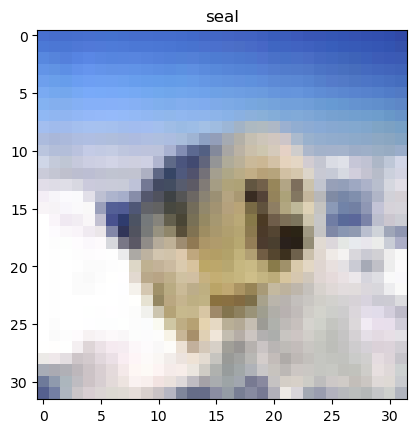

In [3]:

labels = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl',
          'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair',
          'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
          'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
          'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle',
          'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
          'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon',
          'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail',
          'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone',
          'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',
          'wolf', 'woman', 'worm']

print('Número de elementos en el dataset = ',X_train.shape[0]+X_validation.shape[0])
plt.title(labels[int(y_train[62])])
plt.imshow(X_train[62])
plt.show()

### 3. Modelo Base

Primero fijamos un modelo base para entrenar el dataset.

In [ ]:
 #capas de la red
input = Input(shape=(32,32,3))
layer = input
layer = Conv2D(filters=60, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Conv2D(filters=60, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Conv2D(filters=60, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Flatten()(layer)
layer = Dense(units=1000, activation='relu')(layer)
layer = Dense(units=1000, activation='relu')(layer)
output = Dense(units=100, activation='softmax')(layer)

# creamos el modelo
model = Model(inputs=input, outputs=output)
print(model.summary())

# optimizador
optimizer = Adam(learning_rate=0.001)

# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)

# métrica
metrics = ['accuracy']

# compilamos el modelo
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(x=X_train, y=y_train, batch_size=50, epochs=30,
                    validation_data=(X_validation, y_validation))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 60)        1680      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 60)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 60)        32460     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 60)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 60)          32460 

2023-02-08 13:15:31.654274: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-08 13:15:31.655066: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


None
Epoch 1/30
1000/1000 [==============================] - 48s 47ms/step - loss: 3.7611 - accuracy: 0.1172 - val_loss: 3.2148 - val_accuracy: 0.2125
Epoch 2/30
1000/1000 [==============================] - 47s 47ms/step - loss: 2.9577 - accuracy: 0.2603 - val_loss: 2.7576 - val_accuracy: 0.3002
Epoch 3/30
1000/1000 [==============================] - 47s 47ms/step - loss: 2.5343 - accuracy: 0.3442 - val_loss: 2.5744 - val_accuracy: 0.3469
Epoch 4/30
1000/1000 [==============================] - 47s 47ms/step - loss: 2.2073 - accuracy: 0.4144 - val_loss: 2.4291 - val_accuracy: 0.3865
Epoch 5/30
1000/1000 [==============================] - 47s 47ms/step - loss: 1.9066 - accuracy: 0.4812 - val_loss: 2.4111 - val_accuracy: 0.3945
Epoch 6/30
1000/1000 [==============================] - 47s 47ms/step - loss: 1.6175 - accuracy: 0.5479 - val_loss: 2.4307 - val_accuracy: 0.4039
Epoch 7/30
1000/1000 [==============================] - 47s 47ms/step - loss: 1.3145 - accuracy: 0.6240 - val_loss: 2.5

Este modelo no esta muy grande pero sigue teniendo grande problema de overfitting vs alto accuracy en data de training. 

In [ ]:
show_history(history)

Como vemos en resultados, accuracy estaba maximizado y perdida esta minimizado en set de training pero en sets de test conseguimos el aravez. eso enseña que tenemos overfiting y eso empieza alrededor epoca 2-3. Ahora intentaremos mejorar este modelo utilizando methodos siguentes

In [ ]:
print("Evaluate on validation data")
results = model.evaluate(X_validation, y_validation, batch_size=128)
print('val loss:',results[0], 'val acc:', results[1])

### Small model
Probamos un modelo más pequeño para encontrar si sigue teniendo la misma problema.

In [ ]:
# capas de la red

input = Input(shape=(32,32,3))
layer = input
layer = Conv2D(filters=25, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Conv2D(filters=50, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Conv2D(filters=10, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Flatten()(layer)
layer = Dense(units=200, activation='relu')(layer)
layer = Dense(units=100, activation='relu')(layer)
output = Dense(units=100, activation='softmax')(layer)


# creamos el modelo
model = Model(inputs=input, outputs=output)
print(model.summary())

# optimizador
optimizer = Adam(learning_rate=0.001)

# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)

# métrica
metrics = ['accuracy']

# compilamos el modelo
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(x=X_train, y=y_train, batch_size=50, epochs=30,
                    validation_data=(X_validation, y_validation))

In [ ]:
show_history(history)

In [ ]:
print("Evaluate on validation data")
results = model.evaluate(X_validation, y_validation, batch_size=128)
print('val loss:',results[0], 'val acc:', results[1])

Con este modelo no conseguimos un buen resultado, tampoco no evitamos overfitting. El mas validacion score conseguimos es 32%. 

### Early Stopping

Ahora probamos cuantos epochas puede ser mas eficiente.  

In [ ]:

# capas de la red
input = Input(shape=(32,32,3))
layer = input
layer = Conv2D(filters=20, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Conv2D(filters=40, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Conv2D(filters=60, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Flatten()(layer)
layer = Dense(units=1000, activation='relu')(layer)
output = Dense(units=100, activation='softmax')(layer)

# creamos el modelo
model = Model(inputs=input, outputs=output)
print(model.summary())

# optimizador
optimizer = Adam(learning_rate=0.001)

# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)

# métrica
metrics = ['accuracy']

# compilamos el modelo
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Podemos decidir que score queremos monitorizar, cuantas epochs esperar después del mejor score y si queremos que nos devuelva el mejor modelo.
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights=True)

history = model.fit(x=X_train, y=y_train, batch_size=50, epochs=30,
                    validation_data=(X_validation, y_validation), callbacks=[early_stopping])



In [ ]:
show_history(history)

In [ ]:
print("Evaluate on validation data")
results = model.evaluate(X_validation, y_validation, batch_size=128)
print('val loss:',results[0], 'val acc:', results[1])

Modelo para en epoca 30. con este combinacion de neuronas. Podemos llagar hasta 38% accuracy en data set de validacion.

### Regularización L2
Vamos mejorando el modelo con un poco mas grande y regularizacion L2.

In [ ]:
from tensorflow.keras.regularizers import l2

# capas de la red
input = Input(shape=(32,32,3))
layer = input

layer = Conv2D(filters=30, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2(0.001))(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Conv2D(filters=30, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2(0.001))(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Conv2D(filters=30, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2(0.001))(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Flatten()(layer)
layer = Dense(units=100, activation='relu', kernel_regularizer=l2(0.001))(layer)
layer = Dense(units=100, activation='relu', kernel_regularizer=l2(0.001))(layer)
output = Dense(units=100, activation='softmax')(layer)

# creamos el modelo
model = Model(inputs=input, outputs=output)
print(model.summary())

# optimizador
optimizer = Adam(learning_rate=0.001)

# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)

# métrica
metrics = ['accuracy']

# compilamos el modelo
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(x=X_train, y=y_train, batch_size=50, epochs=30,
                    validation_data=(X_validation, y_validation))

In [ ]:
show_history(history)

In [ ]:
print("Evaluate on validation data")
results = model.evaluate(X_validation, y_validation, batch_size=128)
print('val loss:',results[0], 'val acc:', results[1])

In [ ]:
show_history(history)

### Dropout
Podemos introducir en distintas partes de la red las capas dropout para apagar de manera aleatoria las neuronas y así impedir que se produzca overfiting.
Cuanto mayor es el ratio de dropout mayor será la regularización.
No es necesario introducir las capas dropout en todas las capas de la red.

In [ ]:
from tensorflow.keras.layers import Dropout

# capas de la red
input = Input(shape=(32,32,3))
layer = input
layer = Conv2D(filters=20, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Conv2D(filters=40, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Conv2D(filters=60, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Flatten()(layer)
layer = Dense(units=1000, activation='relu')(layer)

layer = Dropout(0.7)(layer)
output = Dense(units=100, activation='softmax')(layer)

# creamos el modelo
model = Model(inputs=input, outputs=output)
print(model.summary())

# optimizador
optimizer = Adam(learning_rate=0.001)

# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)

# métrica
metrics = ['accuracy']

# compilamos el modelo
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(x=X_train, y=y_train, batch_size=50, epochs=30,
                    validation_data=(X_validation, y_validation))

In [ ]:
show_history(history)

In [ ]:
print("Evaluate on validation data")
results = model.evaluate(X_validation, y_validation, batch_size=128)
print('val loss:',results[0], 'val acc:', results[1])

### Data Augmentation
El data augmentation es uno de los mejores métodos de regularización.
Consigue aumentar virtualmente el dataset haciendo que el modelo sea muy robusto y que su performance en validation sea muy buena.
Con ello conseguimos reducir el overfiting y además que el modelo sea robusto frente a pequeñas perturbaciones en las imágenes.
Vamos a implementar un data augmentation que se aplicará durante el entrenamiento, para ello usaremos la clase tensorflow.data.Dataset.
Las funciones que vamos a usar son propias de tensorflow, con ello aseguramos un máximo rendimiento y fiabilidad del entrenamiento.
También se puede implementar usando generadores o con un generador de keras.

2022-12-11 22:36:17.766566: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-11 22:36:17.767127: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


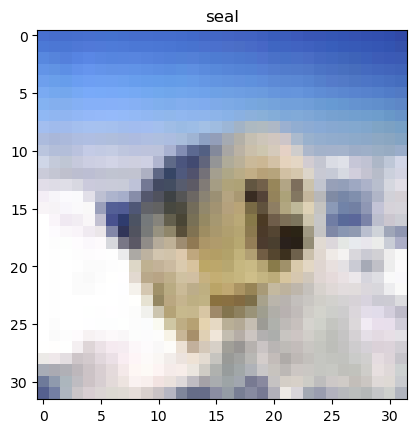

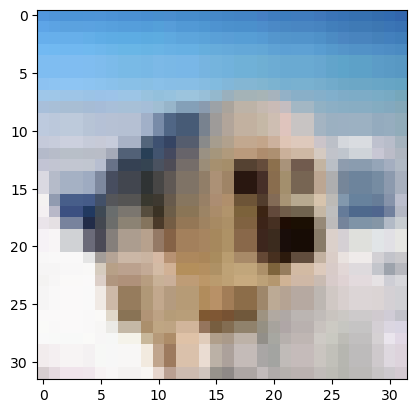

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


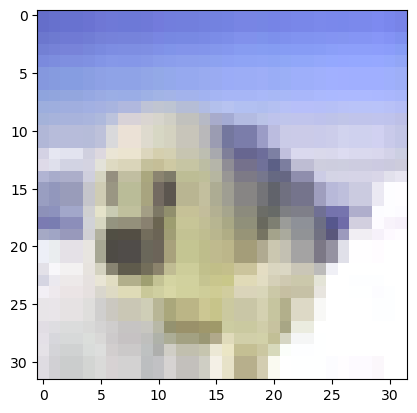

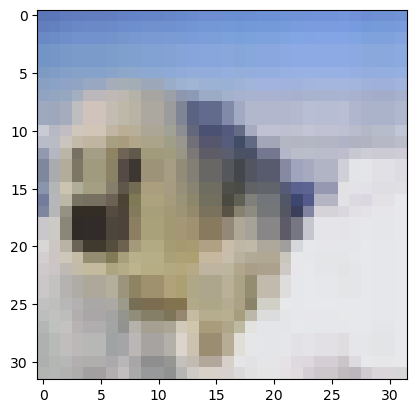

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


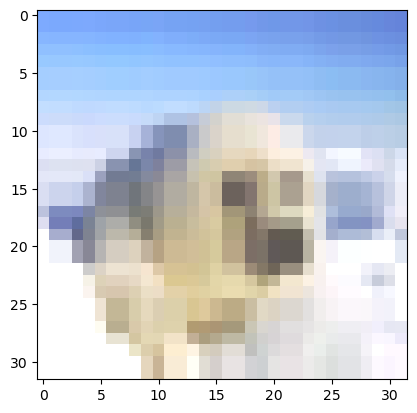

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


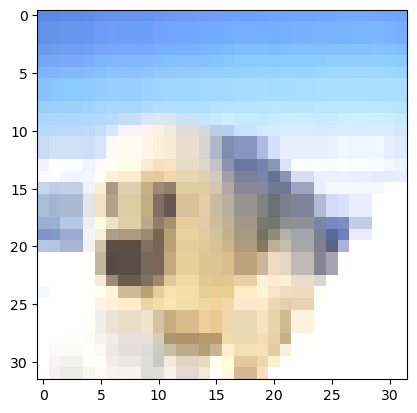

In [4]:
from tensorflow.data import Dataset

# Creamos un Dataset utilizando numpys
train_ds = Dataset.from_tensor_slices((X_train, y_train))
val_ds = Dataset.from_tensor_slices((X_validation, y_validation))

# Seleccionamos el batch_size que
batch_size = 30

# Creamos una función que perturbará de forma aleatoria las imágenes.
# Las etiquetas quedan invariantes
def processing_data(image, label):
    
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_saturation(image, 0.8, 1.2)
    image = tf.image.random_hue(image, 0.05)
    image = tf.image.resize(image, (40,40), method='nearest',antialias=False)
    image = tf.image.random_crop(image, (32,32,3))
    return image, label


# Esta función hará las modificaciones pertinentes al dataset para poder usarlo durante el entrenamiento
def data_aug(ds: Dataset, shuffle=False, augment=False):
    # Hacemos que el dataset se repita de manera indefinida
    ds = ds.repeat() #burda dataset kendini tekrar ediyor

    # Aleatorizamos el dataset usando un buffer de 5000
    if shuffle:
        ds = ds.shuffle(5000)

    # Aplicamos las transformaciones pertinentes
    if augment:
        ds = ds.map(processing_data,num_parallel_calls=4)

    # Hacemos que el dataset este formado por batches
    ds = ds.batch(batch_size)

    # Devolvemos el dataset precargándolo
    return ds.prefetch(buffer_size=4)

# Aplicamos la función data_aug a nuestro dataset
train_ds = data_aug(train_ds, shuffle=True, augment=True)
# Al dataset de validación no le aplicamos perturbaciones
val_ds = data_aug(val_ds)


# Visualizemos unos ejemplos de como la función processing_data modifica las imágenes
plt.title(labels[int(y_train[62])])
plt.imshow(X_train[62])
plt.show()
for _ in range(5):
    image_mod = np.array(processing_data(X_train[62], 0)[0])
    plt.imshow(image_mod)
    plt.show()


In [ ]:
# capas de la red
input = Input(shape=(32,32,3))
layer = input
layer = Conv2D(filters=20, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Conv2D(filters=40, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Conv2D(filters=60, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Flatten()(layer)
layer = Dense(units=1000, activation='relu')(layer)
output = Dense(units=100, activation='softmax')(layer)

# creamos el modelo
model = Model(inputs=input, outputs=output)
print(model.summary())

# optimizador
optimizer = Adam(learning_rate=0.001)

# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)

# métrica
metrics = ['accuracy']

# compilamos el modelo
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Usamos los dataset creados con tensorflow.data.Dataset para entrenar nuesto modelo
history = model.fit(train_ds, batch_size=50, epochs=50,
                    steps_per_epoch=1000, validation_data=val_ds, validation_steps=200)

In [ ]:
show_history(history)

Claramente se ha reducido el overfiting y hemos obtenido unos buenos resultados durante el entrenamiento.
Hemos obtenido un score de 78.4%

In [ ]:
print("Evaluate on validation data")
results = model.evaluate(X_validation, y_validation, batch_size=128)
print('val loss:',results[0], 'val acc:', results[1])

### Batch size correcto
Con el Batch size modificamos:
- La calidad de aprendizaje
- La velocidad de aprendizaje
- La duración del aprendizaje


Con recursos tenemos, no podemos un model que puede tener o un modelo para compara con otros methodos de optimizaciones. Pero podemos ver relacion dentro batch size y socres.


In [ ]:
scores_bs = []
epochs_train_bs = []


In [ ]:
for bs in range(5,30):
    # capas de la red
    input = Input(shape=(32,32,3))
    layer = input
    layer = Conv2D(filters=20, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
    layer = MaxPooling2D((2, 2))(layer)
    layer = Conv2D(filters=40, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
    layer = MaxPooling2D((2, 2))(layer)
    layer = Conv2D(filters=60, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
    layer = MaxPooling2D((2, 2))(layer)
    layer = Flatten()(layer)
    layer = Dense(units=1000, activation='relu')(layer)
    output = Dense(units=100, activation='softmax')(layer)

    # creamos el modelo
    model = Model(inputs=input, outputs=output)
    print(model.summary())

    # optimizador
    optimizer = Adam(learning_rate=0.001)

    # función loss
    loss = SparseCategoricalCrossentropy(from_logits=False)

    # métrica
    metrics = ['accuracy']

    # compilamos el modelo
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, mode='max', restore_best_weights=True)

    history = model.fit(x=X_train, y=y_train, batch_size=bs, epochs=10,
                    validation_data=(X_validation, y_validation), callbacks=[early_stopping])
    scores_bs.append(model.evaluate(X_validation, y_validation, batch_size=128)[1])
    epochs_train_bs.append(len(history.history['loss']))


In [ ]:
plt.plot(scores_bs)
plt.title('Select correct Batch Size')
plt.ylabel('Accuracy value (%)')
plt.xlabel('Batch Size')
plt.show()

Con batches que probamos con modelo muy muy basico llegamos a conclusion que batch size 14 es mejor. Seguro que con mas neuronas, puede ser diferente. 

### Batch Normalization
Podemos añadir capas de Batch Normalization en cualquier parte de la red excepto en la última.
Con ello conseguimos que en todo momento los inputs de las layers estén en los rangos deseados.
Veamos un ejemplo de red profunda sin BN

Añadimos batch normalizacion a todas siguentes capas de Maxpooling2D

In [ ]:
# capas de la red
input = Input(shape=(32,32,3))
layer = input
layer = Conv2D(filters=20, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = BatchNormalization()(layer)
layer = Conv2D(filters=40, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = BatchNormalization()(layer)
layer = Conv2D(filters=60, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = BatchNormalization()(layer)
layer = Flatten()(layer)
layer = BatchNormalization()(layer)
layer = Dense(units=1000, activation='relu')(layer)
output = Dense(units=100, activation='softmax')(layer)

# creamos el modelo
model = Model(inputs=input, outputs=output)
print(model.summary())

# optimizador
optimizer = Adam(learning_rate=0.001)

# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)

# métrica
metrics = ['accuracy']

# compilamos el modelo
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(x=X_train, y=y_train, batch_size=15, epochs=30,
                    validation_data=(X_validation, y_validation))

In [ ]:
show_history(history)

In [ ]:
print("Evaluate on validation data")
results = model.evaluate(X_validation, y_validation, batch_size=128)
print('val loss:',results[0], 'val acc:', results[1])

En este caso el modelo se ha entrenado correctamente, obteniendo un score de 38%.

### Combinación de varias optimizaciones
Vamos a probar a utilizar varias de las optimizaciones vistas

In [6]:
from tensorflow.keras.regularizers import l2
# capas de la red
input = Input(shape=(32,32,3))
layer = input
layer = Conv2D(filters=20, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2(0.001))(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = BatchNormalization()(layer)
layer = Conv2D(filters=40, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2(0.001))(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = BatchNormalization()(layer)
layer = Conv2D(filters=60, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2(0.001))(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = Conv2D(filters=20, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2(0.001))(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = BatchNormalization()(layer)
layer = Flatten()(layer)
layer = Dense(units=1000, activation='relu')(layer)
layer = Dropout(0.7)(layer)
output = Dense(units=100, activation='softmax')(layer)

# creamos el modelo
model = Model(inputs=input, outputs=output)
print(model.summary())

# optimizador
optimizer = Adam(learning_rate=0.001)

# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)

# métrica
metrics = ['accuracy']

# compilamos el modelo
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights=True)

history = model.fit(train_ds, batch_size=20, epochs=20,
                    steps_per_epoch=1000, validation_data=val_ds, validation_steps=200, callbacks=[early_stopping])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 20)        560       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 20)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 20)       80        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 40)        7240      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 40)         0     

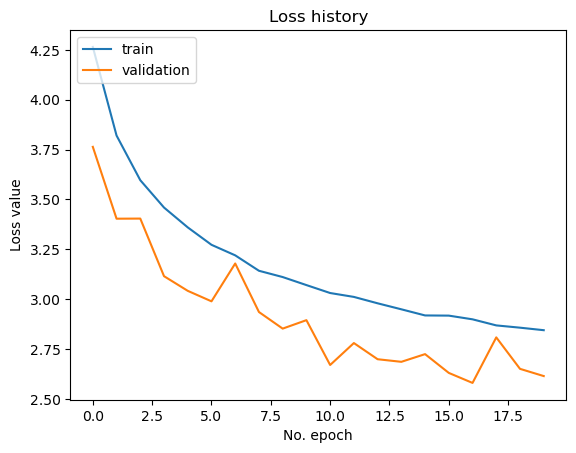

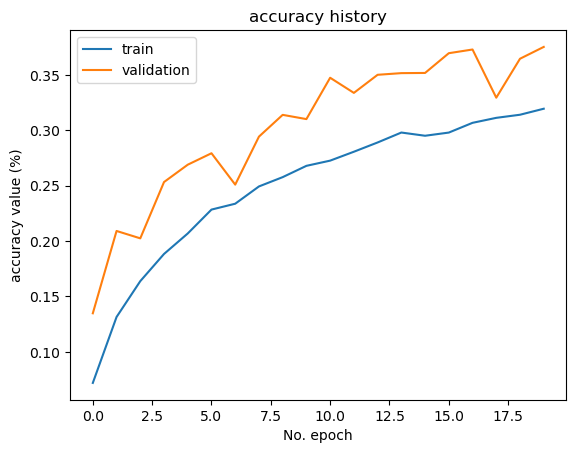

In [7]:
show_history(history)

In [8]:
print("Evaluate on validation data")
results = model.evaluate(X_validation, y_validation, batch_size=128)
print('val loss:',results[0], 'val acc:', results[1])

Evaluate on validation data
79/79 [==============================] - 4s 49ms/step - loss: 2.6234 - accuracy: 0.3729
val loss: 2.623398780822754 val acc: 0.37290000915527344


Combinacion de los variables no funciona bien 37% es accuracy llegada

Con nuestro model funciona mejor data augmentation y drop out hasta 44% pero utilizando juntos no nos da mejores resultados.

